<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Algorithmic Trading 

**Chapter 08 &mdash; CFD Trading with Oanda**

## The Oanda API

`pip install git+https://github.com/yhilpisch/tpqoa.git`

In [1]:
import tpqoa

In [2]:
api = tpqoa.tpqoa('../../pyalgo.cfg')  # adjust the path/filename

## Retrieving Historical Data

### Looking Up Instruments Available for Trading

In [3]:
api.get_instruments()[:15]

[('AUD/CAD', 'AUD_CAD'),
 ('AUD/CHF', 'AUD_CHF'),
 ('AUD/HKD', 'AUD_HKD'),
 ('AUD/JPY', 'AUD_JPY'),
 ('AUD/NZD', 'AUD_NZD'),
 ('AUD/SGD', 'AUD_SGD'),
 ('AUD/USD', 'AUD_USD'),
 ('Australia 200', 'AU200_AUD'),
 ('Brent Crude Oil', 'BCO_USD'),
 ('Bund', 'DE10YB_EUR'),
 ('CAD/CHF', 'CAD_CHF'),
 ('CAD/HKD', 'CAD_HKD'),
 ('CAD/JPY', 'CAD_JPY'),
 ('CAD/SGD', 'CAD_SGD'),
 ('CHF/HKD', 'CHF_HKD')]

### Backtesting a Momentum Strategy on Minute Bars

In [4]:
help(api.get_history)

Help on method get_history in module tpqoa.tpqoa:

get_history(instrument, start, end, granularity, price, localize=True) method of tpqoa.tpqoa.tpqoa instance
    Retrieves historical data for instrument.
    
    Parameters
    instrument: string
        valid instrument name
    start, end: datetime, str
        Python datetime or string objects for start and end
    granularity: string
        a string like 'S5', 'M1' or 'D'
    price: string
        one of 'A' (ask), 'B' (bid) or 'M' (middle)
    
    Returns
    data: pd.DataFrame
        pandas DataFrame object with data



In [5]:
instrument = 'EUR_USD'
start = '2020-05-27'
end = '2020-05-29'
granularity = 'M1'
price = 'M'

In [6]:
data = api.get_history(instrument, start, end,
                      granularity, price)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2822 entries, 2020-05-27 00:00:00 to 2020-05-28 23:59:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         2822 non-null   float64
 1   h         2822 non-null   float64
 2   l         2822 non-null   float64
 3   c         2822 non-null   float64
 4   volume    2822 non-null   int64  
 5   complete  2822 non-null   bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 135.0 KB


In [8]:
data[['c', 'volume']].head()

,c,volume
time,,
2020-05-27 00:00:00,1.09788,34
2020-05-27 00:01:00,1.09776,31
2020-05-27 00:02:00,1.09763,27
2020-05-27 00:03:00,1.09764,25
2020-05-27 00:04:00,1.09768,20


In [9]:
import numpy as np

In [10]:
data['returns'] = np.log(data['c'] / data['c'].shift(1))

In [11]:
cols = []

In [12]:
for momentum in [15, 30, 60, 120]:
    col = 'position_{}'.format(momentum)
    data[col] = np.sign(data['returns'].rolling(momentum).mean())
    cols.append(col)

In [13]:
from pylab import plt
plt.style.use('seaborn-v0_8')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

In [14]:
strats = ['returns']

In [15]:
for col in cols:
    strat = 'strategy_{}'.format(col.split('_')[1])
    data[strat] = data[col].shift(1) * data['returns']
    strats.append(strat)

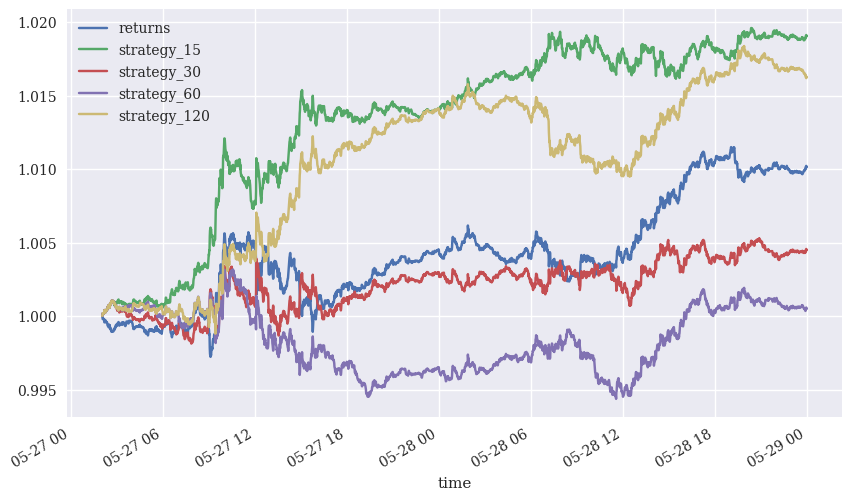

In [16]:
data[strats].dropna().cumsum(
    ).apply(np.exp).plot(figsize=(10, 6));

### Factoring In Leverage and Margin

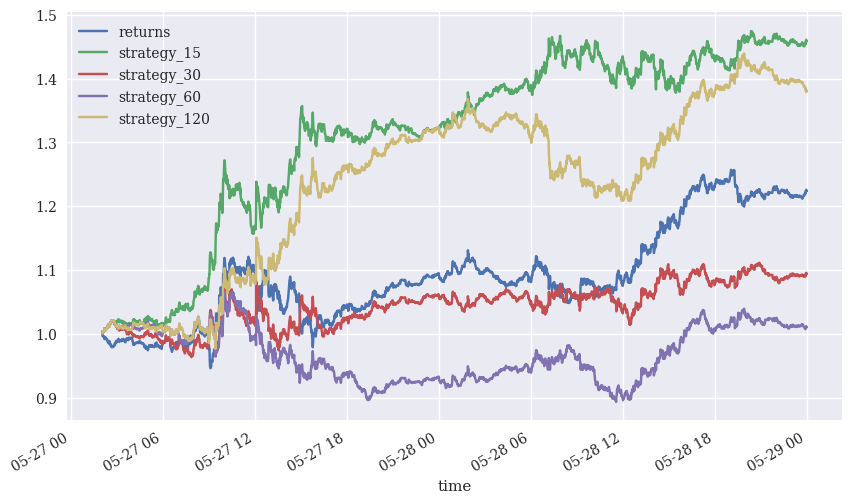

In [17]:
data[strats].dropna().cumsum().apply(
            lambda x: x * 20).apply(np.exp).plot(figsize=(10, 6));

## Working with Streaming Data

In [18]:
instrument = 'EUR_USD'

In [19]:
api.stream_data(instrument, stop=10)

2023-10-09T14:42:45.528985081Z 1.05415 1.05431
2023-10-09T14:42:46.054462627Z 1.05417 1.05432
2023-10-09T14:42:46.683050018Z 1.05419 1.05433
2023-10-09T14:42:46.742038533Z 1.05419 1.05434
2023-10-09T14:42:47.320651790Z 1.05417 1.05433
2023-10-09T14:42:47.700971598Z 1.05421 1.05437
2023-10-09T14:42:48.152504882Z 1.0542 1.05435
2023-10-09T14:42:48.790723573Z 1.05422 1.05436
2023-10-09T14:42:49.062271644Z 1.05426 1.05442
2023-10-09T14:42:49.492833250Z 1.05424 1.05439


## Placing Orders

In [20]:
help(api.create_order)

Help on method create_order in module tpqoa.tpqoa:

create_order(instrument, units, price=None, sl_distance=None, tsl_distance=None, tp_price=None, comment=None, touch=False, suppress=False, ret=False) method of tpqoa.tpqoa.tpqoa instance
    Places order with Oanda.
    
    Parameters
    instrument: string
        valid instrument name
    units: int
        number of units of instrument to be bought
        (positive int, eg 'units=50')
        or to be sold (negative int, eg 'units=-100')
    price: float
        limit order price, touch order price
    sl_distance: float
        stop loss distance price, mandatory eg in Germany
    tsl_distance: float
        trailing stop loss distance
    tp_price: float
        take profit price to be used for the trade
    comment: str
        string
    touch: boolean
        market_if_touched order (requires price to be set)
    suppress: boolean
        whether to suppress print out
    ret: boolean
        whether to return the order obje

In [21]:
api.create_order(instrument, 1000)



 {'id': '3770', 'time': '2023-10-09T14:42:49.809832455Z', 'userID': 13834683, 'accountID': '101-004-13834683-001', 'batchID': '3769', 'requestID': '79174751500380563', 'type': 'ORDER_FILL', 'orderID': '3769', 'instrument': 'EUR_USD', 'units': '1000.0', 'gainQuoteHomeConversionFactor': '0.943740727425', 'lossQuoteHomeConversionFactor': '0.953225558856', 'price': 1.05439, 'fullVWAP': 1.05439, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.05424, 'liquidity': '10000000'}], 'asks': [{'price': 1.05439, 'liquidity': '10000000'}], 'closeoutBid': 1.05424, 'closeoutAsk': 1.05439}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '101277.6315', 'tradeOpened': {'tradeID': '3770', 'units': '1000.0', 'price': 1.05439, 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.0711', 'initialMarginRequired': '33.3'}, 'halfSpreadCost': '0.0711'} 



In [22]:
api.create_order(instrument, -1500)



 {'id': '3772', 'time': '2023-10-09T14:42:49.991479864Z', 'userID': 13834683, 'accountID': '101-004-13834683-001', 'batchID': '3771', 'requestID': '79174751500380794', 'type': 'ORDER_FILL', 'orderID': '3771', 'instrument': 'EUR_USD', 'units': '-1500.0', 'gainQuoteHomeConversionFactor': '0.943740727425', 'lossQuoteHomeConversionFactor': '0.953225558856', 'price': 1.05424, 'fullVWAP': 1.05424, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.05424, 'liquidity': '10000000'}], 'asks': [{'price': 1.05439, 'liquidity': '9999000'}], 'closeoutBid': 1.05424, 'closeoutAsk': 1.05439}, 'reason': 'MARKET_ORDER', 'pl': '-0.143', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '101277.4885', 'tradeOpened': {'tradeID': '3772', 'units': '-500.0', 'price': 1.05424, 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.0356', 'initialMarginRequired': '16.65'}, 'tradesClosed': [{'tradeID': '3770', 'units': '-1000.0', 'price': 1.05424, 'realizedPL': '-0.143'

In [23]:
api.create_order(instrument, 500)



 {'id': '3774', 'time': '2023-10-09T14:42:50.211255132Z', 'userID': 13834683, 'accountID': '101-004-13834683-001', 'batchID': '3773', 'requestID': '43145954487786026', 'type': 'ORDER_FILL', 'orderID': '3773', 'instrument': 'EUR_USD', 'units': '500.0', 'gainQuoteHomeConversionFactor': '0.943754153833', 'lossQuoteHomeConversionFactor': '0.953239120203', 'price': 1.05437, 'fullVWAP': 1.05437, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.05423, 'liquidity': '9998500'}], 'asks': [{'price': 1.05437, 'liquidity': '9999000'}], 'closeoutBid': 1.05423, 'closeoutAsk': 1.05437}, 'reason': 'MARKET_ORDER', 'pl': '-0.062', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '101277.4265', 'tradesClosed': [{'tradeID': '3772', 'units': '500.0', 'price': 1.05437, 'realizedPL': '-0.062', 'financing': '0.0', 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.0332'}], 'halfSpreadCost': '0.0332'} 



## Implementing Trading Strategies in Real-Time

In [24]:
import MomentumTrader as MT

In [25]:
mt = MT.MomentumTrader('../../pyalgo.cfg',
                       instrument=instrument,
                       bar_length='15s',
                       momentum=6,
                       units=10000)

In [26]:
mt.stream_data(mt.instrument, stop=150)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 

 {'id': '3776', 'time': '2023-10-09T14:44:45.718489443Z', 'userID': 13834683, 'accountID': '101-004-13834683-001', 'batchID': '3775', 'requestID': '43145954970290130', 'type': 'ORDER_FILL', 'orderID': '3775', 'instrument': 'EUR_USD', 'units': '10000.0', 'gainQuoteHomeConversionFactor': '0.943588581187', 'lossQuoteHomeConversionFactor': '0.953071883511', 'price': 1.05456, 'fullVWAP': 1.05456, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.05441, 'liquidity': '10000000'}], 'asks': [{'price': 1.05456, '

In [27]:
oo = mt.create_order(instrument, units=-mt.position * mt.units,
                     ret=True, suppress=True)
oo

{'id': '3778',
 'time': '2023-10-09T14:44:45.977051910Z',
 'userID': 13834683,
 'accountID': '101-004-13834683-001',
 'batchID': '3777',
 'requestID': '25131556458581565',
 'type': 'ORDER_FILL',
 'orderID': '3777',
 'instrument': 'EUR_USD',
 'units': '-10000.0',
 'gainQuoteHomeConversionFactor': '0.943588581187',
 'lossQuoteHomeConversionFactor': '0.953071883511',
 'price': 1.05441,
 'fullVWAP': 1.05441,
 'fullPrice': {'type': 'PRICE',
  'bids': [{'price': 1.05441, 'liquidity': '10000000'}],
  'asks': [{'price': 1.05456, 'liquidity': '9990000'}],
  'closeoutBid': 1.05441,
  'closeoutAsk': 1.05456},
 'reason': 'MARKET_ORDER',
 'pl': '-1.4296',
 'financing': '0.0',
 'commission': '0.0',
 'guaranteedExecutionFee': '0.0',
 'accountBalance': '101275.9969',
 'tradesClosed': [{'tradeID': '3776',
   'units': '-10000.0',
   'price': 1.05441,
   'realizedPL': '-1.4296',
   'financing': '0.0',
   'guaranteedExecutionFee': '0.0',
   'halfSpreadCost': '0.7112'}],
 'halfSpreadCost': '0.7112'}

### Retrieving Account Information

In [28]:
api.get_account_summary()

{'id': '101-004-13834683-001',
 'alias': 'Primary',
 'currency': 'EUR',
 'balance': '101275.9969',
 'createdByUserID': 13834683,
 'createdTime': '2020-03-19T06:08:14.363139403Z',
 'guaranteedStopLossOrderMode': 'ALLOWED',
 'pl': '1470.9529',
 'resettablePL': '1470.9529',
 'resettablePLTime': '0',
 'financing': '-194.956',
 'commission': '0.0',
 'guaranteedExecutionFees': '0.0',
 'marginRate': '0.0333',
 'openTradeCount': 0,
 'openPositionCount': 0,
 'pendingOrderCount': 0,
 'hedgingEnabled': False,
 'unrealizedPL': '0.0',
 'NAV': '101275.9969',
 'marginUsed': '0.0',
 'marginAvailable': '101275.9969',
 'positionValue': '0.0',
 'marginCloseoutUnrealizedPL': '0.0',
 'marginCloseoutNAV': '101275.9969',
 'marginCloseoutMarginUsed': '0.0',
 'marginCloseoutPercent': '0.0',
 'marginCloseoutPositionValue': '0.0',
 'withdrawalLimit': '101275.9969',
 'marginCallMarginUsed': '0.0',
 'marginCallPercent': '0.0',
 'lastTransactionID': '3778'}

In [29]:
api.get_transactions(tid=int(oo['id']) - 2)

[{'id': '3777',
  'time': '2023-10-09T14:44:45.977051910Z',
  'userID': 13834683,
  'accountID': '101-004-13834683-001',
  'batchID': '3777',
  'requestID': '25131556458581565',
  'type': 'MARKET_ORDER',
  'instrument': 'EUR_USD',
  'units': '-10000.0',
  'timeInForce': 'FOK',
  'positionFill': 'DEFAULT',
  'reason': 'CLIENT_ORDER'},
 {'id': '3778',
  'time': '2023-10-09T14:44:45.977051910Z',
  'userID': 13834683,
  'accountID': '101-004-13834683-001',
  'batchID': '3777',
  'requestID': '25131556458581565',
  'type': 'ORDER_FILL',
  'orderID': '3777',
  'instrument': 'EUR_USD',
  'units': '-10000.0',
  'gainQuoteHomeConversionFactor': '0.943588581187',
  'lossQuoteHomeConversionFactor': '0.953071883511',
  'price': 1.05441,
  'fullVWAP': 1.05441,
  'fullPrice': {'type': 'PRICE',
   'bids': [{'price': 1.05441, 'liquidity': '10000000'}],
   'asks': [{'price': 1.05456, 'liquidity': '9990000'}],
   'closeoutBid': 1.05441,
   'closeoutAsk': 1.05456},
  'reason': 'MARKET_ORDER',
  'pl': '-1

In [30]:
api.print_transactions(tid=int(oo['id']) - 18)

3762 | 2023-10-09T07:30:53.38 | EUR_USD |    500.0 |  -0.0906
3764 | 2023-10-09T07:32:29.79 | EUR_USD |   1000.0 |      0.0
3766 | 2023-10-09T07:32:29.96 | EUR_USD |  -1500.0 |  -0.1526
3768 | 2023-10-09T07:32:30.16 | EUR_USD |    500.0 |  -0.0763
3770 | 2023-10-09T14:42:49.80 | EUR_USD |   1000.0 |      0.0
3772 | 2023-10-09T14:42:49.99 | EUR_USD |  -1500.0 |   -0.143
3774 | 2023-10-09T14:42:50.21 | EUR_USD |    500.0 |   -0.062
3776 | 2023-10-09T14:44:45.71 | EUR_USD |  10000.0 |      0.0
3778 | 2023-10-09T14:44:45.97 | EUR_USD | -10000.0 |  -1.4296


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>